In [1]:
from jax import jit, random
import pandas as pd
from datetime import datetime, timedelta
import numpyro
from numpyro import distributions as dist
from numpyro import infer
import arviz as az
from IPython.display import Markdown
from plotly.express.colors import qualitative as qual_colours
from pathlib import Path
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown

from estival.sampling import tools as esamp

from emu_renewal.process import CosineMultiCurve
from emu_renewal.distributions import GammaDens
from emu_renewal.renew import RenewalDeathsModel, ModelDeathsResult, RenewalHospModel
from emu_renewal.outputs import get_spaghetti, get_quant_df_from_spaghetti, get_spagh_df_from_dict
from emu_renewal.plotting import plot_uncertainty_patches, plot_3d_spaghetti, plot_post_prior_comparison, plot_spaghetti_calib_comparison
from emu_renewal.calibration import StandardCalib
from emu_renewal.utils import get_adjust_idata_index, adjust_summary_cols
from emu_renewal.targets import UniformDispTarget, HalfNormalDispTarget, FixedDispTarget

In [2]:
PROJECT_PATH = Path.cwd().resolve()
DATA_PATH = PROJECT_PATH.parent / "data/covid_aus"

In [3]:
# Get data
target_data = pd.read_csv(DATA_PATH / "WHO-COVID-19-global-data_21_8_24.csv")
seroprev_data = pd.read_csv(DATA_PATH / "aus_seroprev_data.csv")

# Clean cases data
aust_data = target_data.loc[target_data["Country"] == "Australia"]
aust_data.index = pd.to_datetime(aust_data["Date_reported"], format="%d/%m/%Y")
aust_cases = aust_data["New_cases"].resample("W-SUN").interpolate(method="linear").fillna(0.0)
aust_deaths = aust_data["New_deaths"]

# Clean seroprevalence data
seroprev_data.index = pd.to_datetime(seroprev_data["date"])
aust_seroprev = seroprev_data["seroprevalence"]

# Hospitalisation data
aust_hosp = pd.read_pickle(DATA_PATH / "hosp.pkl")

In [4]:
# Specify fixed parameters and get calibration data
proc_update_freq = 14
init_time = 50
pop = 26e6
analysis_start = datetime(2021, 12, 1)
analysis_end = datetime(2022, 10, 1)
init_start = analysis_start - timedelta(init_time)
init_end = analysis_start - timedelta(1)
select_data = aust_cases.loc[analysis_start: analysis_end]
select_deaths = aust_deaths.loc[analysis_start: analysis_end]
hosp_data = aust_hosp[analysis_start: analysis_end]
init_data = aust_cases.resample("D").asfreq().interpolate().loc[init_start: init_end] / 7.0

In [5]:
# Define parameter ranges
priors = {
    "gen_mean": dist.TruncatedNormal(7.3, 0.5, low=1.0),
    "gen_sd": dist.TruncatedNormal(3.8, 0.5, low=1.0),
    "cdr": dist.Beta(15, 15), #(16,40)
    "ifr": dist.Beta(3, 20),
    "rt_init": dist.Normal(0.0, 0.25),
    "report_mean": dist.TruncatedNormal(8.0, 0.5, low=1.0),
    "report_sd": dist.TruncatedNormal(3.0, 0.5, low=1.0),
    "death_mean": dist.TruncatedNormal(18.0, 0.5, low=1.0),
    "death_sd": dist.TruncatedNormal(5.0, 0.5, low=1.0),
    "admit_mean": dist.TruncatedNormal(10.0, 0.5, low=1.0),
    "admit_sd": dist.TruncatedNormal(5.0, 0.5, low=1.0),
    "stay_mean": dist.TruncatedNormal(10.0, 0.5, low=1.0),
    "stay_sd": dist.TruncatedNormal(5.0, 0.5, low=1.0),
    "har": dist.Beta(5, 10),
    "shared_dispersion": dist.HalfNormal(0.5),
}

In [6]:
# Define model and fitter
proc_fitter = CosineMultiCurve()
renew_model = RenewalHospModel(pop, analysis_start, analysis_end, proc_update_freq, proc_fitter, GammaDens(), init_time, init_data, GammaDens())

In [20]:
# Define calibration and calib data
calib_data = {
    "weekly_sum": FixedDispTarget(select_data, "shared_dispersion"),
    "seropos": FixedDispTarget(aust_seroprev, "shared_dispersion"),
    "weekly_deaths": FixedDispTarget(select_deaths, "shared_dispersion"),
}
calib = StandardCalib(renew_model, priors, calib_data)

In [21]:
# Run calibration
kernel = infer.NUTS(calib.calibration, dense_mass=True, init_strategy=calib.custom_init(radius=0.5))
mcmc = infer.MCMC(kernel, num_chains=2, num_samples=1000, num_warmup=1000)
mcmc.run(random.PRNGKey(1))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [22]:
# Grab sample of data from calibrated model outputs
idata = az.from_dict(mcmc.get_samples(True))
idata_sampled = az.extract(idata, num_samples=20)
sample_params = esamp.xarray_to_sampleiterator(idata_sampled)

In [23]:
spaghetti = get_spagh_df_from_dict(get_spaghetti(calib, sample_params))

In [24]:
plot_spaghetti_calib_comparison(spaghetti, calib.targets, ["weekly_sum", "weekly_deaths", "seropos"])

In [25]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
admit_mean         10.007  0.510   9.047   10.947      0.009    0.006   
admit_sd            4.986  0.505   4.049    5.904      0.009    0.006   
cdr                 0.554  0.057   0.446    0.654      0.001    0.001   
death_mean         17.804  0.488  16.901   18.730      0.008    0.006   
death_sd            5.137  0.499   4.224    6.065      0.009    0.006   
dispersion_proc     0.061  0.006   0.051    0.072      0.000    0.000   
gen_mean            5.605  0.530   4.679    6.639      0.012    0.008   
gen_sd              4.525  0.494   3.602    5.420      0.010    0.007   
har                 0.330  0.124   0.114    0.563      0.002    0.002   
ifr                 0.001  0.000   0.001    0.001      0.000    0.000   
proc[0]            -0.138  0.055  -0.235   -0.029      0.001    0.001   
proc[1]            -0.234  0.055  -0.339   -0.135      0.001    0.001   
proc[2]            -0.176  0.052  -0.272   -0.082      0.001    0.001   
proc[3]            -0.036  0.053  -0.138    0.067      0.001    0.001   
proc[4]             0.080  0.053  -0.014    0.178      0.001    0.001   
proc[5]             0.118  0.057   0.014    0.225      0.001    0.001   
proc[6]             0.083  0.051  -0.013    0.178      0.001    0.001   
proc[7]             0.034  0.050  -0.062    0.127      0.001    0.001   
proc[8]             0.015  0.051  -0.079    0.107      0.001    0.001   
proc[9]             0.022  0.050  -0.075    0.109      0.001    0.001   
proc[10]            0.027  0.050  -0.072    0.123      0.001    0.001   
proc[11]            0.055  0.053  -0.051    0.150      0.001    0.001   
proc[12]            0.090  0.054  -0.011    0.192      0.001    0.001   
proc[13]            0.089  0.055  -0.013    0.198      0.001    0.001   
proc[14]            0.044  0.054  -0.049    0.149      0.001    0.001   
proc[15]           -0.010  0.051  -0.098    0.091      0.001    0.001   
proc[16]           -0.030  0.052  -0.135    0.062      0.001    0.001   
proc[17]           -0.011  0.054  -0.118    0.088      0.001    0.001   
proc[18]           -0.001  0.058  -0.118    0.106      0.001    0.001   
proc[19]           -0.002  0.060  -0.118    0.106      0.001    0.002   
proc[20]           -0.001  0.059  -0.112    0.112      0.001    0.002   
proc[21]           -0.000  0.061  -0.118    0.104      0.001    0.001   
report_mean         7.800  0.488   6.914    8.717      0.008    0.006   
report_sd           2.963  0.489   2.060    3.893      0.010    0.007   
rt_init             0.592  0.056   0.492    0.700      0.001    0.001   
shared_dispersion   0.381  0.038   0.319    0.460      0.001    0.001   
stay_mean          10.007  0.484   9.083   10.906      0.009    0.006   
stay_sd             5.002  0.500   4.085    5.953      0.008    0.006   

                   ess_bulk  ess_tail  r_hat  
admit_mean           3626.0    1501.0    1.0  
admit_sd             3154.0    1600.0    1.0  
cdr                  1733.0    1338.0    1.0  
death_mean           3398.0    1468.0    1.0  
death_sd             3375.0    1707.0    1.0  
dispersion_proc      1785.0    1474.0    1.0  
gen_mean             2034.0    1783.0    1.0  
gen_sd               2398.0    1591.0    1.0  
har                  2971.0    1558.0    1.0  
ifr                  1822.0    1482.0    1.0  
proc[0]              3491.0    1597.0    1.0  
proc[1]              2867.0    1530.0    1.0  
proc[2]              3140.0    1361.0    1.0  
proc[3]              3858.0    1671.0    1.0  
proc[4]              2809.0    1634.0    1.0  
proc[5]              2876.0    1456.0    1.0  
proc[6]              3230.0    1696.0    1.0  
proc[7]              2642.0    1548.0    1.0  
proc[8]              3284.0    1537.0    1.0  
proc[9]              3750.0    1756.0    1.0  
proc[10]             3362.0    1217.0    1.0  
proc[11]             3166.0    1568.0    1.0  
proc[12]             3159.0    1547.0    1.0  
proc[13]             3281.0    1352.0    1.0 

array([[<Axes: title={'center': 'admit_mean'}>,
        <Axes: title={'center': 'admit_mean'}>],
       [<Axes: title={'center': 'admit_sd'}>,
        <Axes: title={'center': 'admit_sd'}>],
       [<Axes: title={'center': 'cdr'}>, <Axes: title={'center': 'cdr'}>],
       [<Axes: title={'center': 'death_mean'}>,
        <Axes: title={'center': 'death_mean'}>],
       [<Axes: title={'center': 'death_sd'}>,
        <Axes: title={'center': 'death_sd'}>],
       [<Axes: title={'center': 'dispersion_proc'}>,
        <Axes: title={'center': 'dispersion_proc'}>],
       [<Axes: title={'center': 'gen_mean'}>,
        <Axes: title={'center': 'gen_mean'}>],
       [<Axes: title={'center': 'gen_sd'}>,
        <Axes: title={'center': 'gen_sd'}>],
       [<Axes: title={'center': 'har'}>, <Axes: title={'center': 'har'}>],
       [<Axes: title={'center': 'ifr'}>, <Axes: title={'center': 'ifr'}>],
       [<Axes: title={'center': 'proc'}>,
        <Axes: title={'center': 'proc'}>],
       [<Axes: title=

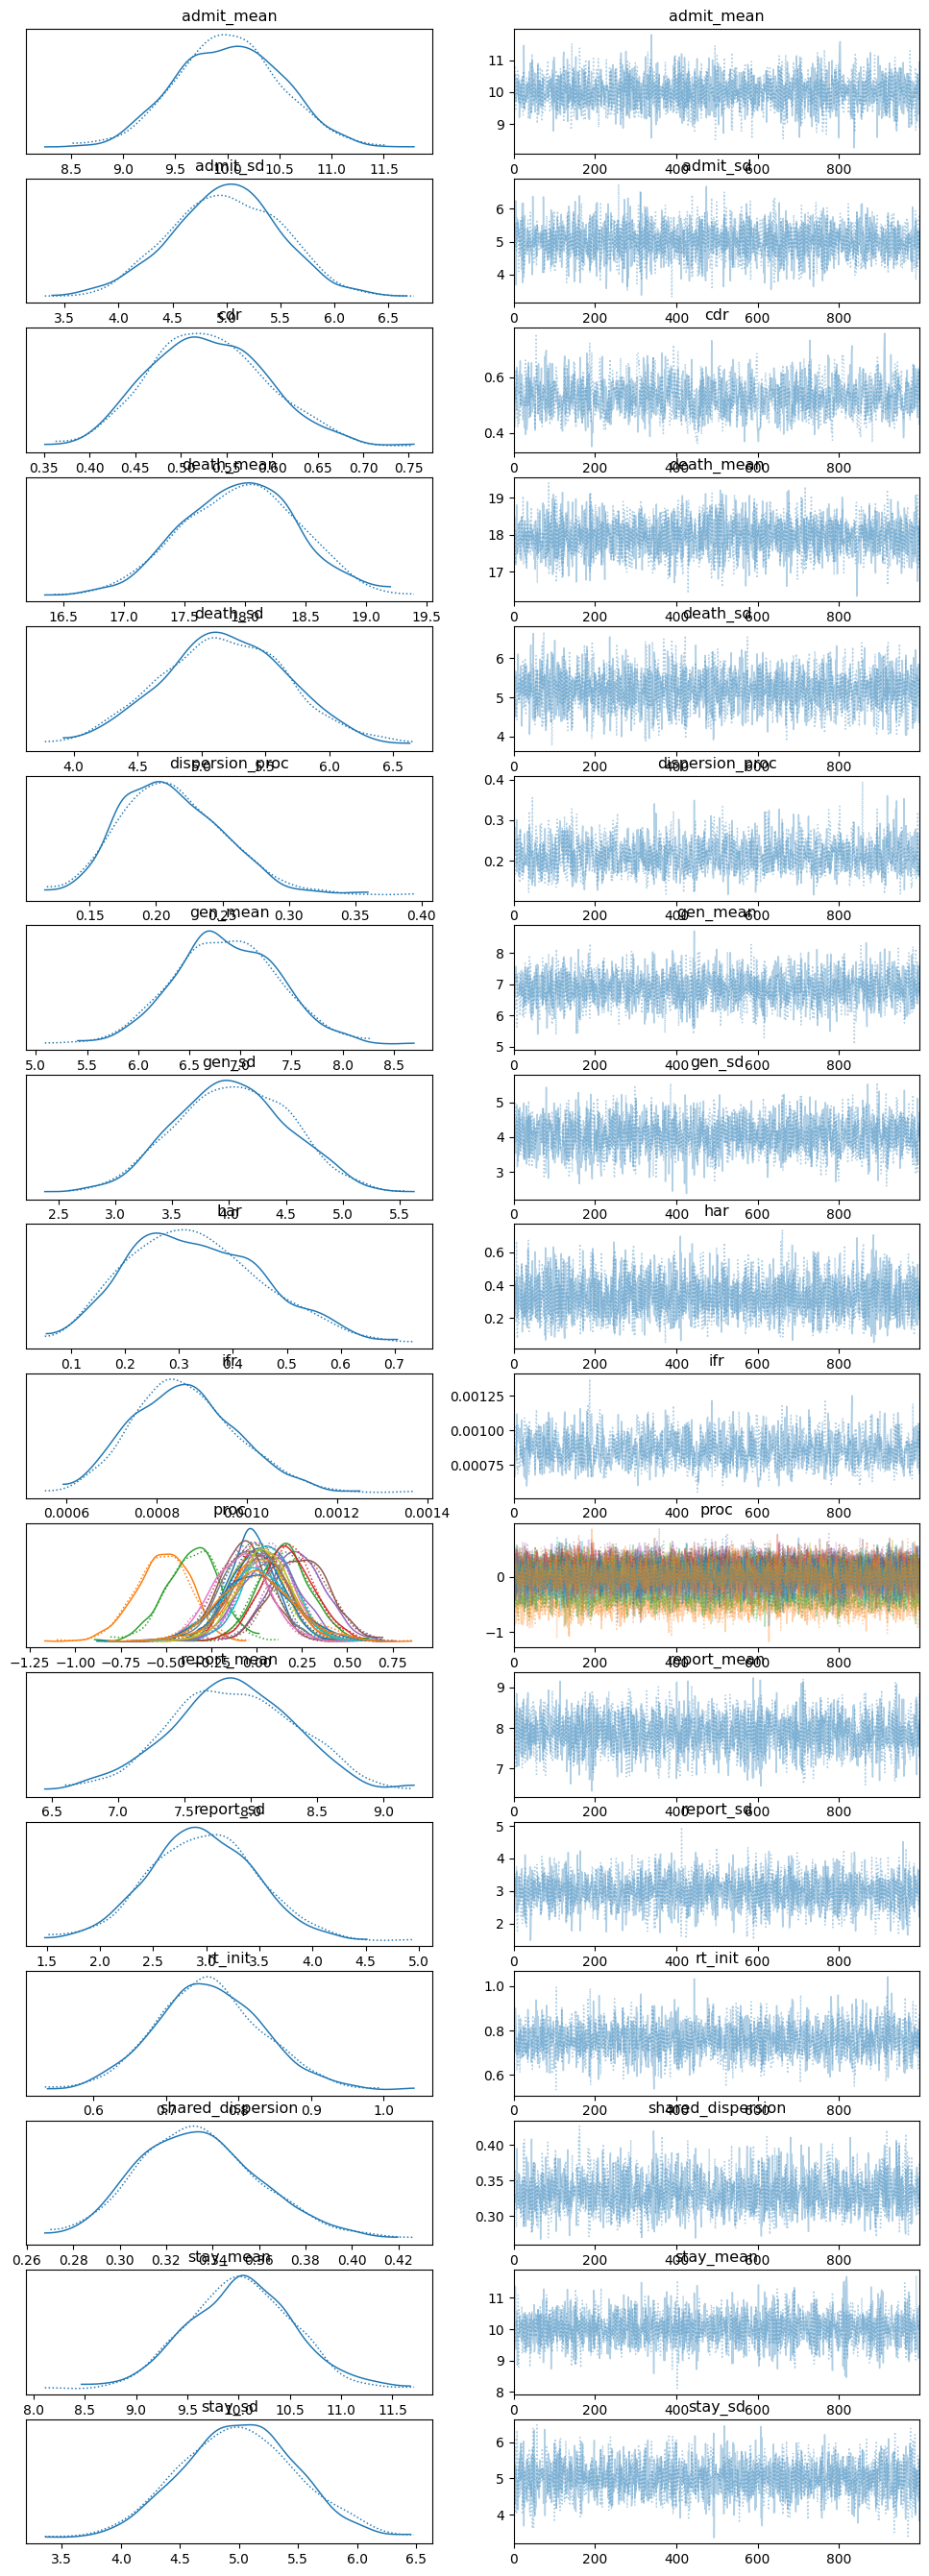

In [13]:
az.plot_trace(idata)

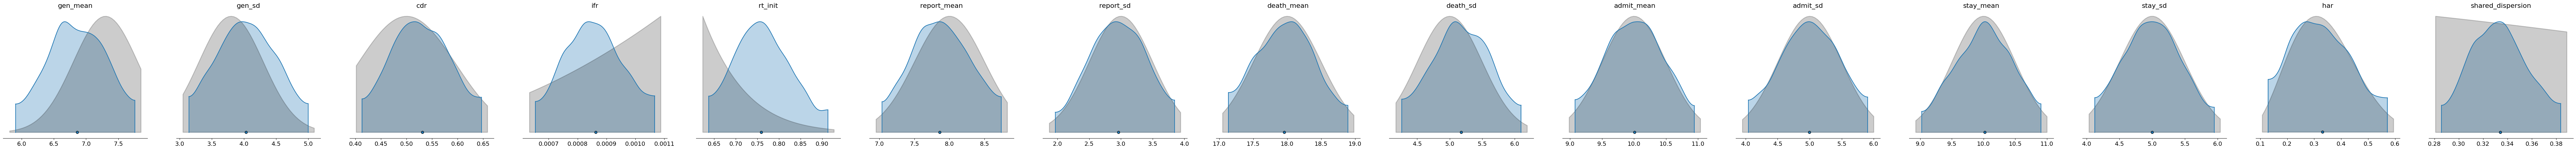

In [14]:
plot_post_prior_comparison(idata, list(priors.keys()), priors);